## 2. 강화학습 문제의 모형화

<div style="text-align: right"> <b>Kwang Myung Yu</b></div>
<div style="text-align: right"> Initial issue : 2023.06.29 </div>
<div style="text-align: right"> last update : 2023.06.29 </div>

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import warnings; warnings.filterwarnings('ignore')
#plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')
%matplotlib inline

# Options for pandas
pd.options.display.max_columns = 200
pd.options.display.max_rows = 100

### 2.2 one-armed bandit, 슬롯머신 문제

한 시행에서 에이전트는 n개의 슬로머신 중 하나를 선택해서 레버를 당긴다.   
한 시행에서 에이전트가 할수 있는 총 동작은 n가지이다.   
이러한 시행을 k번 반복한다.
k번째 시행의 액션 a로 부터 보상 $R_k$f를 받는다.

이 문제를 푸는 전략은 처음 몇번동안 서로 다른 레버를 당겨서 리워드를 관찰하는것이다.  
그 다음 관찰된 보상이 가장 큰 레버를 계속 당기는 것이다.   

이 전략을 위해서 이전 시행들에 기초한 특정 액션의 기대 보상, expected reward라는 개념이 필요하다. k번째 시행에서 액션 a의 기대 보상을 수식으로 $Q_k(a)$라고 표기한다.   
즉 기대 보상은 액션의 함수이며, 이 함수는 액션을 주어진 액션을 취했을 때 기대할 수있는 리워드의 양을 돌려준다.

In [2]:
def exp_reward(action, history):
    rewards_for_action = history[action]
    return sum(rewards_for_action) / len(rewards_for_action)

- 즉 k번째 시행에서 액션 a의 기대 보상은 그때까지 a의 모든 리워드의 산술 평균이다.   
- 따라서 이전 액션들과 관찰은 이후 액션에 영향을 미친다. 이를 이전 동작들이 현재 동작과 미래 동작들을 강화한다고 말할 수 있다.  
- $Q_k(a)$를 뭔가 가치를 말해준다는 점에서 동작 가치함수(action value function)라고 부른다.

기대 보상에 근거해서 최선의 동작을 찾는 코드

In [3]:
def get_best_action(actions):
    best_action = 0
    max_action_value = 0
    for i in range(len(actions)):
        cur_action_value = get_action_value(actions[i])
        if cur_action_value > max_action_value:
            best_action = i
            max_action_value = cur_action_value
            
    return best_action

- 위 방식을 사용하면 아직 시도한 적없는 어쩌면 기대 보상이 더 큰 레버를 선택하는 일은 없다. 
- 이처럼 지금까지의 경험에만 근거해 최선의 것을 선택하는 접근 방식을 greedy method라고 한다.

최선의 동작을 발견하려면 입실론 확률로 무작위 동작을 하고, 1- 입실론 확률로 탐욕법을 적용한다.

In [4]:
n = 10
probs = np.random.rand(n)
eps = 0.1

카지노 슬롯 머신이 10가정하자. 
위에서 n = 10으로 설정함.   

여기서는 랜덤변수를 구해서 그것이 슬롯 머신의 확률보다 작으면 리워드에 1을 더하는 과정을 반복한다.  

In [5]:
import random

def get_reward(prob, n = 10):
    reward = 0
    for i in range(n):
        if random.random() < prob:
            reward += 1
    return reward

예를 들어 슬롯 머신의 확률이 0.7이라고 하자.  
첫번째 루프에서 랜덤 변수가 0.4가 나왔다면 리워드 1을 더하는 방식이다.   

만약 리워드 받는 행위를 여러번 반복하면 평균 보상이 7에 가깝게 된다.

In [6]:
reward_test = [get_reward(0.7) for _ in range(2000)]
print(reward_test)

[6, 9, 8, 8, 6, 6, 8, 5, 7, 8, 6, 7, 7, 7, 7, 7, 7, 9, 8, 5, 10, 5, 8, 7, 8, 6, 8, 5, 5, 5, 8, 8, 7, 8, 6, 9, 9, 7, 6, 5, 4, 5, 8, 8, 8, 6, 8, 6, 7, 6, 9, 9, 8, 9, 5, 8, 6, 8, 9, 7, 5, 6, 7, 10, 6, 8, 4, 7, 7, 5, 7, 8, 9, 6, 5, 7, 5, 7, 5, 8, 4, 8, 8, 6, 4, 8, 5, 7, 8, 7, 6, 9, 9, 6, 6, 5, 4, 9, 8, 8, 6, 9, 6, 8, 8, 9, 8, 9, 8, 5, 6, 7, 4, 8, 6, 6, 8, 7, 7, 8, 7, 8, 9, 5, 8, 7, 5, 5, 9, 5, 10, 5, 8, 9, 5, 9, 8, 6, 6, 7, 3, 9, 6, 5, 7, 7, 7, 7, 8, 7, 9, 8, 8, 7, 7, 8, 9, 6, 6, 7, 9, 5, 10, 6, 6, 6, 6, 9, 8, 6, 4, 4, 9, 7, 7, 5, 6, 6, 6, 5, 5, 8, 6, 10, 6, 5, 5, 3, 5, 6, 7, 6, 5, 7, 6, 6, 7, 7, 5, 8, 8, 8, 6, 9, 10, 6, 8, 6, 7, 7, 8, 5, 9, 8, 10, 9, 5, 7, 8, 8, 8, 7, 8, 10, 7, 7, 7, 8, 6, 7, 8, 7, 7, 7, 8, 9, 6, 7, 9, 6, 5, 5, 9, 8, 4, 6, 3, 7, 7, 7, 7, 10, 4, 8, 8, 8, 7, 7, 8, 9, 7, 6, 6, 8, 8, 8, 8, 7, 7, 6, 7, 7, 8, 7, 6, 8, 7, 5, 2, 5, 8, 6, 8, 9, 8, 7, 6, 6, 7, 9, 6, 8, 4, 7, 6, 9, 7, 8, 9, 6, 7, 7, 6, 9, 8, 6, 8, 7, 10, 8, 7, 9, 7, 7, 8, 6, 6, 6, 9, 6, 7, 8, 8, 9, 5, 7, 6, 8, 7, 9,

In [7]:
np.mean(reward_test)

6.9845

(array([  3.,  15.,  72., 219., 409., 525., 466., 232.,  59.]),
 array([ 2.        ,  2.88888889,  3.77777778,  4.66666667,  5.55555556,
         6.44444444,  7.33333333,  8.22222222,  9.11111111, 10.        ]),
 <BarContainer object of 9 artists>)

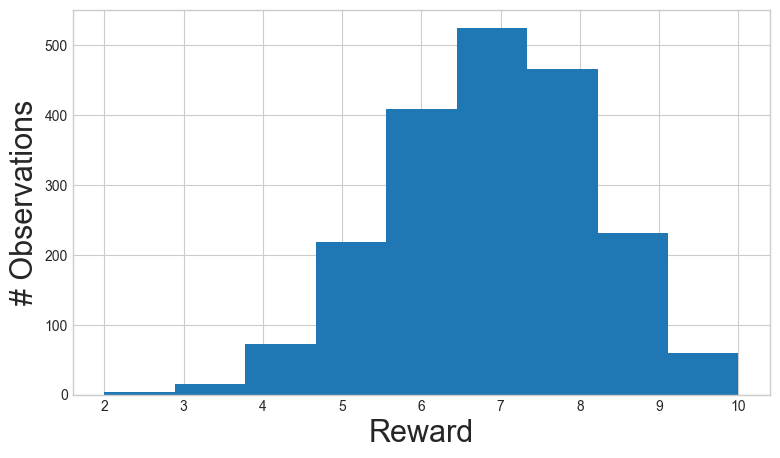

In [8]:
plt.figure(figsize=(9,5))
plt.xlabel("Reward",fontsize=22)
plt.ylabel("# Observations",fontsize=22)
plt.hist(reward_test,bins=9)

이제 greedy method를 구현해보자.  
이를 위해서는 어떤 레버를 담겼고 보상이 어떤지 기록해야함.  
가장 간단한 방법은 파이썬 리스트에 (레버 번호, 리워드) 형태의 튜플을 출가하는 것이다.  
예를 들어 (2, 9)는 2번 레버를 당겨서 9달러의 상금을 얻었음을 뜻함

그런데 위와 같은 방법은 시행을 여러번 할 수록 길어진다.   
간단하게 각 레버의 평균 리워드만 기억하면 된다.

In [9]:
sum = 0
x = [4, 5, 6, 7]

for j in range(len(x)):
    sum = sum + x[j]
    
sum

22

한 레버의 평균 보상을 구한 상태에서 그 레버를 다시 당겨서 새 리워드를 받았을 때 평균을 구하려면 간단하게 다음과 같이 구현하면 된다.  

새 평균 = (k*평균 + 리워드) /(k + 1)

이제 레버가 총 10개라고 하면 다음과 같은 배열을 준비하면 된다.

In [10]:
record = np.zeros((n, 2))
record

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

- 위에서 각 요소의 첫번째는 레버를 당긴 횟수이고, 두번째는 현재까지의 평균이다.  

이제 새 액션과 리워드로 이 배열을 갱신하는 함수를 살펴보자.

In [11]:
def update_record(record, action, r):
    new_r = (record[action, 0] * record[action, 1] + r) / (record[action, 0] + 1)
    record[action, 0] += 1
    record[action, 1] = new_r
    return record

In [12]:
def get_best_arm(record):
    arm_index = np.argmax(record[:, 1], axis = 0)
    return arm_index

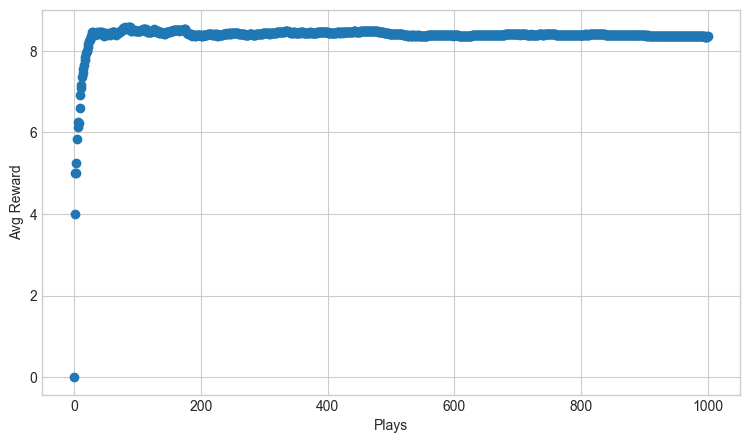

In [13]:
fig, ax = plt.subplots(1, 1)
ax.set_xlabel("Plays")
ax.set_ylabel("Avg Reward")
fig.set_size_inches(9, 5)

record = np.zeros((n, 2))
probs = np.random.rand(n)

eps = 0.2
rewards  = [0]

for i in range(1000):
    if random.random() > eps:
        choice = get_best_arm(record)
    else:
        choice = np.random.randint(10)
        
    r = get_reward(probs[choice])
    record =  update_record(record, choice, r)
    mean_reward = ((i+1) * rewards[-1] + r)/(i+2)
    rewards.append(mean_reward)

ax.scatter(np.arange(len(rewards)),rewards)